# Results
In this notebook, we define and calculate the statistics of our tests.

In [3]:
# load gold standard

import json
import pandas as pd
fileName = "gold_standard.json"
goldStandard = {}

with open(fileName,'r',encoding='utf-8') as file:
    data = json.load(file)
    goldStandardRaw = {case["id"]: case["differential_diagnosis"].split("\n") for case in data}

for caseId, case in goldStandardRaw.items():
    goldStandard[caseId] = pd.Series(gs.split("-")[-1].strip().lower() for gs in case)
    
goldStandard['220']


0                      polycythemia vera
1    leukemia (chronic myeloid leukemia)
dtype: object

In [4]:
# load results

import json
import pandas as pd
from collections import defaultdict
fileName = "CaseReviewTest-2021-11-09 (2).json"
results = {}

with open(fileName, 'r', encoding='utf-8') as file:
    data = json.load(file)
    resultsCollected = defaultdict(lambda: dict())
    for test in data:
        resultsCollected[test["case_number"]][test["app"]] = \
            [result.strip().lower() for result in test["content"].split(";")]

    resultsNormalized = defaultdict(lambda: {})
    for caseId, result in resultsCollected.items():
        maxSize = max(len(ddx) for ddx in result.values())
        for app, ddx in result.items():
            resultsNormalized[caseId][app] = ddx + \
                [None] * (maxSize - len(ddx))

for caseId, case in resultsNormalized.items():
    results[caseId] = pd.DataFrame(case, columns=sorted(case.keys()))

results['60']


,Ada,Avey,Babylon,Buoy,K health,WebMD
0,endometriosis,adenomyosis,,primary dysmenorrhea,endometriosis,primary dysmenorrhea
1,primary dysmenorrhea,endometriosis,None,endometriosis,primary dysmenorrhea,uterine fibroids
2,chronic pelvic pain,primary dysmenorrhea,None,uterine fibroids,None,endometriosis
3,adenomyosis,secondary dysmenorrhea,None,None,None,pelvic inflammatory disease
4,None,None,None,None,None,cervicitis
5,None,None,None,None,None,interstitial cystitis
6,None,None,None,None,None,irritable bowel syndrome
7,None,None,None,None,None,fibromyalgia


In [5]:
results['13']

,Ada,Avey,Babylon,Buoy,K health,WebMD
0,chronic bronchitis,chronic obstructive pulmonary disease,chronic bronchitis,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease,bronchitis
1,asthma,asthma,stable angina,chronic bronchitis,asthma,pneumonia
2,chronic obstructive pulmonary disease,valvular heart disease,lung cancer,chronic lung issue,None,coronavirus
3,None,lung cancer,None,None,None,congestive heart failure
4,None,acute bronchitis,None,None,None,asthma
5,None,pulmonary edema,None,None,None,chronic obstructive pulmonary disease


In [6]:
# append cold standard to case
cases = dict()
for caseId, gs in goldStandard.items():
    if caseId in results:
        cases[caseId] = pd.DataFrame(results[caseId])
        cases[caseId].insert(loc=0, column="gs", value=gs)


In [7]:
cases['89']

,gs,Ada,Avey,Babylon,Buoy,K health,WebMD
0,otitis media,otitis media,otitis media,,coronavirus disease 2019,,otitis media
1,otitis media with effusion,common cold,tonsillopharyngitis,None,otitis externa,None,swimmer's ear
2,otitis externa,burst ear drum,None,None,None,None,adenoidal hypertrophy
3,NaN,mastoiditis,None,None,None,None,ruptured eardrum
4,NaN,flu,None,None,None,None,acute adenoiditis
5,NaN,None,None,None,None,None,airplane ear
6,NaN,None,None,None,None,None,acute sinusitis
7,NaN,None,None,None,None,None,tonsilitis
8,NaN,None,None,None,None,None,scarlet fever
9,NaN,None,None,None,None,None,hearing loss


## Let us define the metrics now.

### Terms used
- TP: True positive
- TN: True negative
- FP: False positive
- FN: False negative

### Precision
$$precision = \frac{TP}{TP + FP} = \frac{TP}{\text{length of differential list}}$$

### Recall
$$recall = \frac{TP}{TP + FN} = \frac{TP}{\text{length of the gold standard}}$$

### F1 Score
Suppose $\beta$ defines how important is $recall$ to $precision$ then,
$$fscore_{\beta} = (1 + \beta^2)\frac{precision \cdot recall}{(\beta^2 \cdot precision) + recall}$$
Substituting $\beta = 1$,
$$fscore_{1} = \frac{2 \cdot precision \cdot recall}{ precision + recall}$$

### NDCG
NDCG or Normalized Discounted Cumulative Gain is measure of how accurate the ranking is. In our calculations, we use
$$DCG = \sum_{i=1}^n\frac{2^{relevance_i}-1}{log_2(i+1)}$$
where $n$ is the number of differentials in the returned list and  
$relevance_i = |gold standard| - rank_{gold\ standard}(ddx[i])$ if $ddx[i]$ is present, 0 otherwise.

$$NDCG = \frac{DCG_{ddx}}{DCG_{gold\ standard}}$$

### M Score
M Score determines where the top disease (gold standard) appears in the returned differential.
$$M_i = \text{gold standard[0]} \in \text{ddx[:i]}$$

### Position
Shows the position of the gold standard[0] in the returned differential. 

### Length
$$length = \frac{|ddx|}{|gold\ standard|}$$


In [8]:
import math


def getPrecision(goldStandard: pd.Series, candidate: pd.Series) -> float:
    tp = sum(int(disease in goldStandard.values and disease is not None)
             for disease in candidate)
    return tp if tp == 0 else tp/candidate.count()


def getRecall(goldStandard: pd.Series, candidate: pd.Series) -> float:
    tp = sum(int(disease in goldStandard.values and disease is not None)
             for disease in candidate)
    return tp/goldStandard.count()


def getF1Score(precision: float, recall: float) -> float:
    return math.nan if precision+recall == 0 else 2*precision*recall/(precision+recall)


def getNDCG(goldStandard: pd.Series, candidate: pd.Series, scores) -> float:
    def discount(score: float, index: int) -> float:
        return (math.pow(2, score)-1)/math.log2(index+1)
        # return (math.pow(2,score)-1)/math.log2(index+1)

    maxDCG = sum(discount(scores[i], i+1) for i in range(len(scores)))

    candidateRelevance = []
    for index, disease in enumerate(candidate):
        goldStandard = list(goldStandard)
        if disease is not None and disease in goldStandard:
            candidateRelevance.append(
                discount(scores[goldStandard.index(disease)], index+1))
        else:
            candidateRelevance.append(0)

    return sum(candidateRelevance)/maxDCG


def getMScore(goldStandard: pd.Series, candidate: pd.Series, m=1) -> bool:
    return goldStandard.values[0] in candidate.values[:m]


def getPosition(goldStandard: pd.Series, candidate: pd.Series) -> bool:
    return math.nan if goldStandard.values[0] not in candidate.values else 1 + list(candidate.values).index(goldStandard.values[0])


def getLength(goldStandard: pd.Series, candidate: pd.Series) -> int:
    return math.nan if candidate.count() == 0 else candidate.count()/goldStandard.count()


def getScoresCase(case: pd.DataFrame) -> pd.DataFrame:
    scores = [
        [getPrecision(case.iloc[:, 0], case.iloc[:, i])
         for i in range(1, len(case.columns))],
        [getRecall(case.iloc[:, 0], case.iloc[:, i])
         for i in range(1, len(case.columns))]
    ]

    scores.append([getF1Score(scores[0][i], scores[1][i])
                  for i in range(len(case.columns)-1)])
    scores.append([getNDCG(case.iloc[:, 0], case.iloc[:, i], list(range(case.iloc[:, 0].count(), 0, -1)))
                  for i in range(1, len(case.columns))])

    for m in range(1, 6, 2):
        scores.append([getMScore(case.iloc[:, 0], case.iloc[:, i], m)
                      for i in range(1, len(case.columns))])

    scores.append([getPosition(case.iloc[:, 0], case.iloc[:, i])
                   for i in range(1, len(case.columns))])

    scores.append([getLength(case.iloc[:, 0], case.iloc[:, i])
                   for i in range(1, len(case.columns))])

    return pd.DataFrame(scores, columns=case.columns[1:],
                        index=["precision", "recall", "f1-score", "NDCG", "M1", "M3", "M5", "position", "length"])


# calculate all scores
scores = {id: getScoresCase(case) for id, case in cases.items()}
scores['89']


,Ada,Avey,Babylon,Buoy,K health,WebMD
precision,0.2,0.5,0,0.5,0,0.066667
recall,0.333333,0.333333,0.0,0.333333,0.0,0.333333
f1-score,0.25,0.4,NaN,0.4,NaN,0.111111
NDCG,0.745253,0.745253,0.0,0.067172,0.0,0.745253
M1,True,True,False,False,False,True
M3,True,True,False,False,False,True
M5,True,True,False,False,False,True
position,1,1,NaN,NaN,NaN,1
length,1.666667,0.666667,0.333333,0.666667,0.333333,5.0


In [9]:
def getAverage(scores, row: int, col: int) -> float:
    values = []
    for id, score in scores.items():
        if not math.isnan(score.iloc[row, col]):
            values.append(score.iloc[row, col])

    return 0 if not values else round(sum(values)/len(values), 3)


averageScores = pd.DataFrame(
    [
        [
            getAverage(scores, row, col)
            for col in range(len(next(iter(scores.values())).columns))
        ]
        for row in range(9)
    ],
    columns=next(iter(scores.values())).columns,
    index=[
        f"average_{x}" for x in [
            "precision", "recall", "f1-score", "NDCG", "M1", "M3", "M5", "position", "length"
        ]
    ]
)

#ignore nan for recall
for col in next(iter(scores.values())).columns:
    p = averageScores.loc["average_precision", col]
    r = averageScores.loc["average_recall", col]
    averageScores.loc["average_f1-score", col] = round(2*p*r/(p+r), 3)

averageScores


,Ada,Avey,Babylon,Buoy,K health,WebMD
average_precision,0.268,0.360,0.011,0.275,0.214,0.115
average_recall,0.354,0.557,0.014,0.257,0.214,0.266
average_f1-score,0.305,0.437,0.012,0.266,0.214,0.161
average_NDCG,0.467,0.690,0.007,0.337,0.267,0.385
average_M1,0.435,0.652,0.000,0.348,0.217,0.348
average_M3,0.565,0.826,0.000,0.435,0.304,0.565
average_M5,0.609,0.870,0.000,0.435,0.348,0.565
average_position,1.500,1.400,0.000,1.300,1.625,1.462
average_length,1.498,1.833,0.524,1.009,0.991,2.375


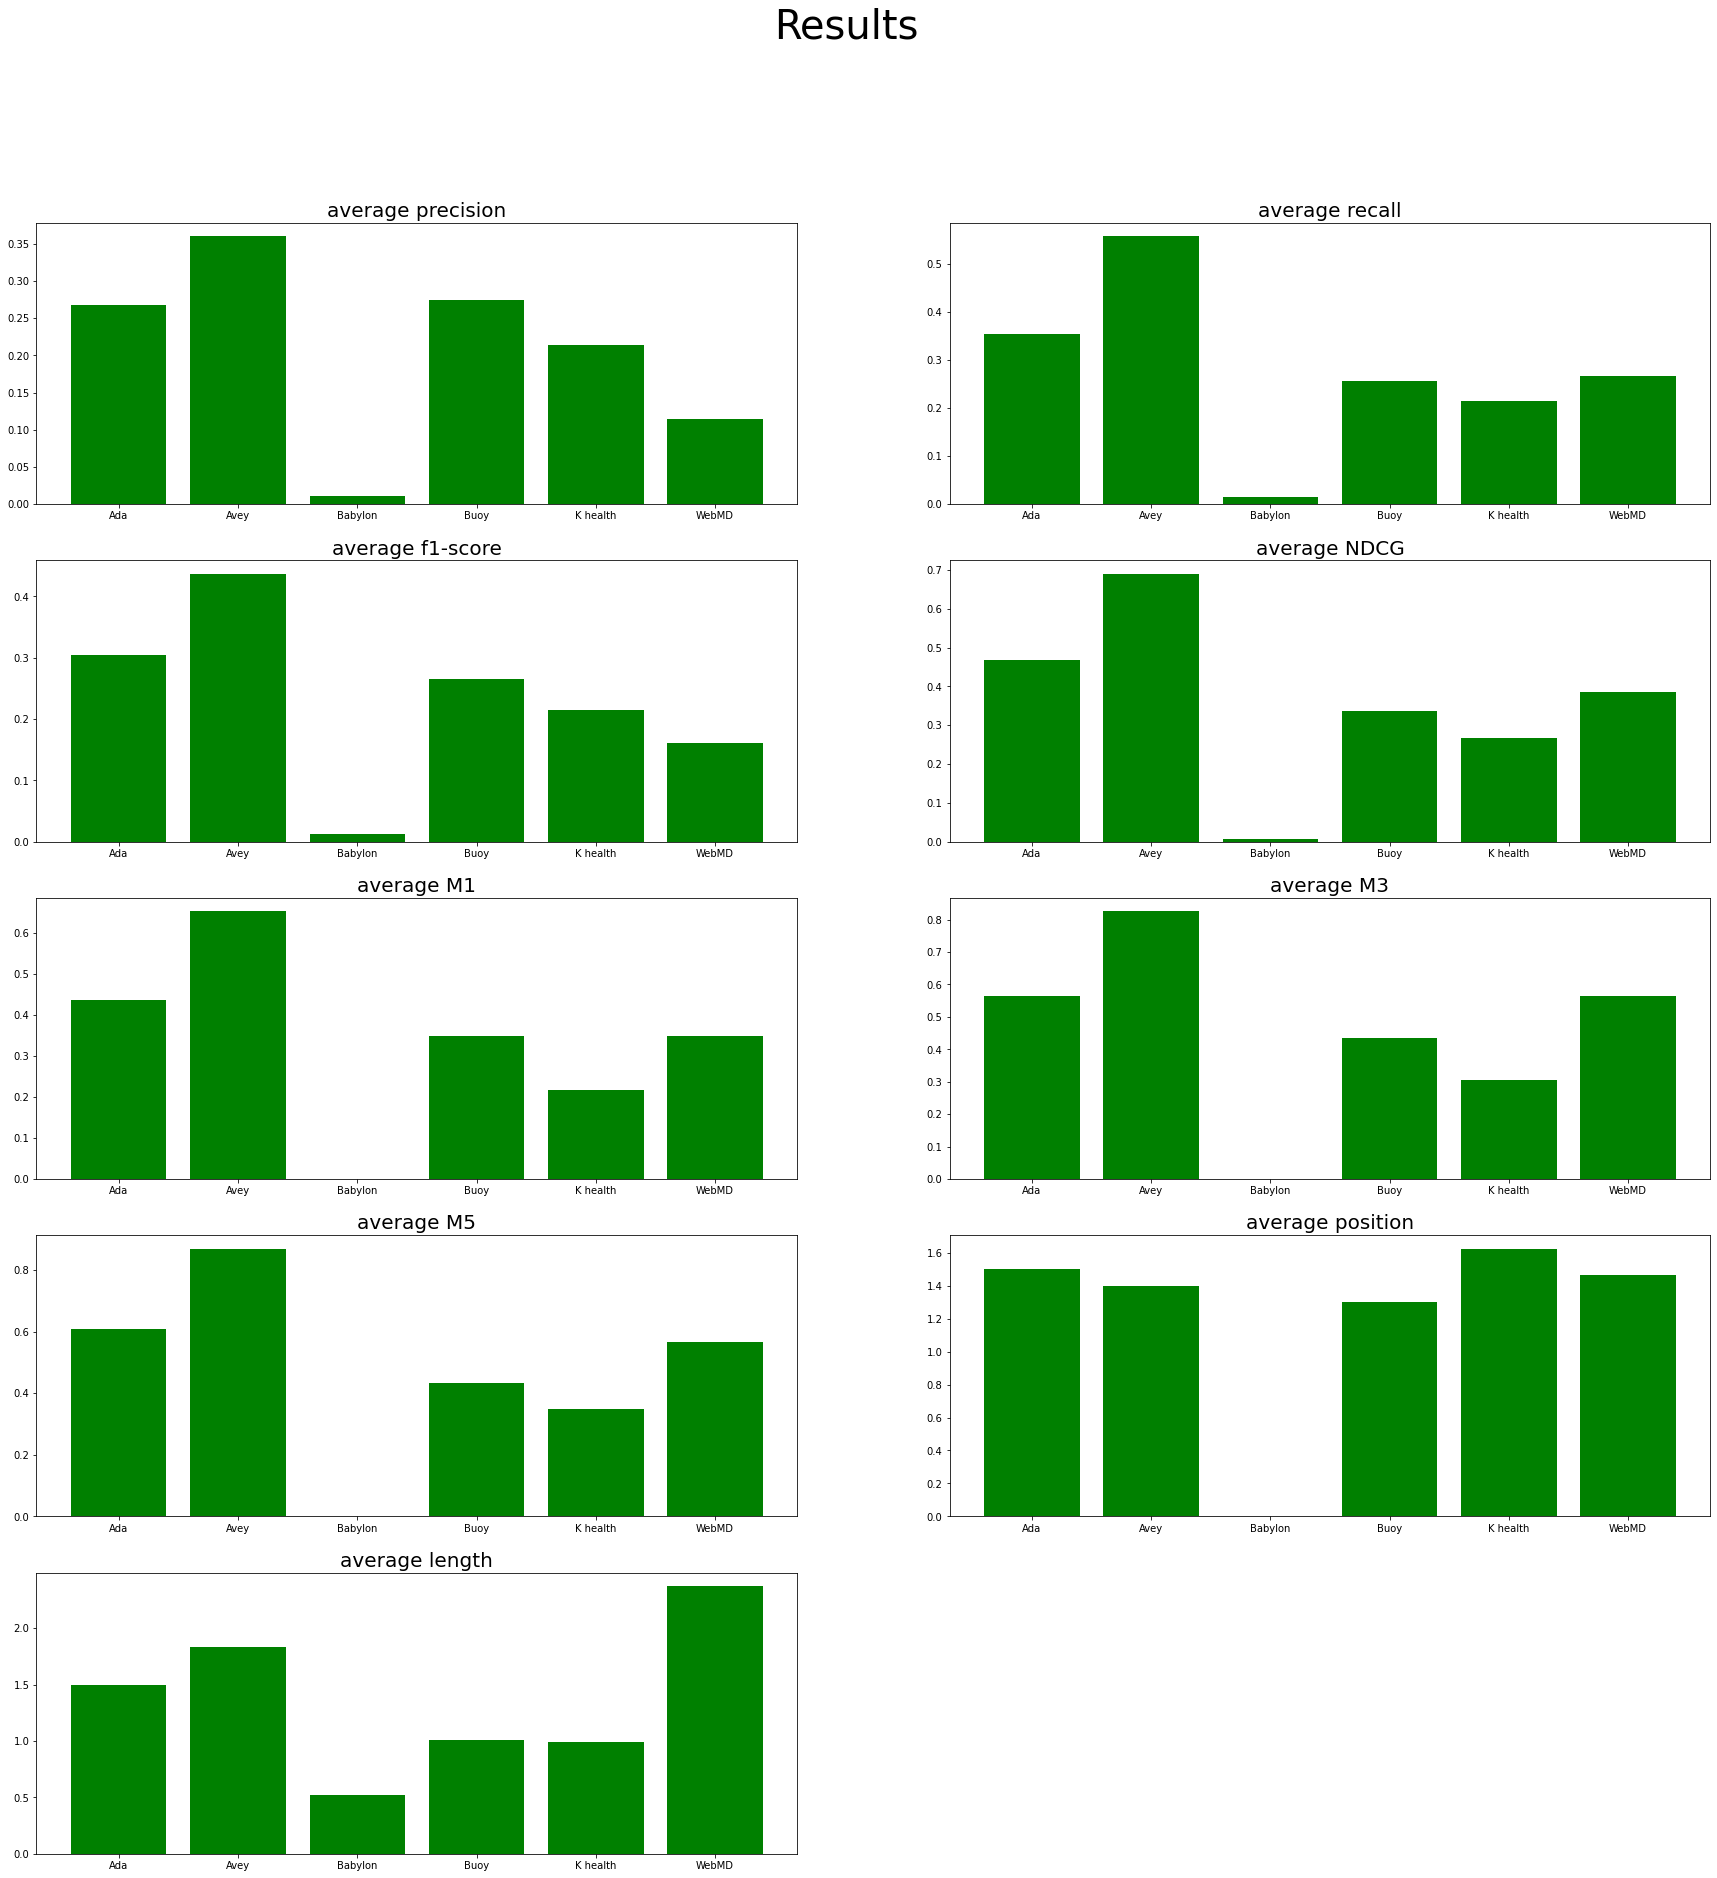

In [46]:
import matplotlib.pyplot as plt
import math

scoresToCompare = pd.DataFrame(averageScores,columns=averageScores.columns)

fig, subplots = plt.subplots(5,2, figsize=(30,30))
fig.suptitle("Results",fontsize=40)

for index, metric in enumerate(scoresToCompare.index.values.tolist()):
    subplots[index//2, index %
             2].bar(scoresToCompare.columns, averageScores.loc[metric],color="green")
    subplots[index//2, index % 2].set_title(metric.replace("_"," "),fontsize=20)


fig.delaxes(subplots[4,1])
plt.show()
